In [1]:
import SimpleITK as sitk
import os

# dltk compatible with tensorflow 1
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import pandas as pd
import time

from matplotlib import pyplot as plt
from dltk.io.augmentation import *
from dltk.io.preprocessing import *

%matplotlib inline

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# Timer helper class for benchmarking reading methods
class Timer(object):
    """Timer class
       Wrap a will with a timing function
    """
    
    def __init__(self, name):
        self.name = name
        
    def __enter__(self):
        self.t = time.time()
        
    def __exit__(self, *args, **kwargs):
        print("{} took {} seconds".format(
        self.name, time.time() - self.t))

In [3]:
# Set up parameters
batch_size = 5
iterations = 100

# Define the desired shapes and types of the training examples to pass to `read_fn`:
reader_params = {'n_examples': 1,
                 'example_size': [128, 224, 224],
                 'extract_examples': True}

reader_example_shapes = {'features': {'x': reader_params['example_size'] + [1,]},
                         'labels': {'y': []}}
 
reader_example_dtypes = {'features': {'x': tf.float32},
                         'labels': {'y': tf.int32}}

### Method 1: Using feed dictionaries

In [4]:
# Read some demo data from csv
all_filenames = pd.read_csv(
    '../DLTK/demographic_HH.csv',
    dtype=object,
    keep_default_na=False,
    na_values=[]).to_numpy()

# For demo purposes, we will only use the first 10 datasets from IXI HH
all_filenames = all_filenames[:10]

In [5]:
def load_data(file_references, mode, params=None):
    
    data = {'features': [], 'labels': []}
    
    # We define a `read_fn` and iterate through the `file_references`, which
    # can contain information about the data to be read (e.g. a file path):
    for meta_data in file_references:
        
        # Here, we parse the `subject_id` to construct a file path to read
        # an image from.
        subject_id = meta_data[0]
        data_path = '../DLTK/1mm'
        t1_fn = os.path.join(data_path, '{}/T1_1mm.nii.gz'.format(subject_id))
        
        # Read the .nii image containing a brain volume with SimpleITK and get 
        # the numpy array:
        sitk_t1 = sitk.ReadImage(t1_fn)
        t1 = sitk.GetArrayFromImage(sitk_t1)

        # Normalise the image to zero mean/unit std dev:
        t1 = whitening(t1)
        
        # Create a 4D Tensor with a dummy dimension for channels
        t1 = t1[..., np.newaxis]

        # Labels: Here, we parse the class *sex* from the file_references 
        # \in [1,2] and shift them to \in [0,1] for training:
        sex = np.int32(meta_data[1]) - 1
        y = sex
        
        # If training should be done on image patches for improved mixing, 
        # memory limitations or class balancing, call a patch extractor
        if params['extract_examples']:
            images = extract_random_example_array(
                t1,
                example_size=params['example_size'],
                n_examples=params['n_examples'])
            
            # Loop the extracted image patches
            for e in range(params['n_examples']):
                data['features'].append(images[e].astype(np.float32))
                data['labels'].append(y.astype(np.int32))
                     
        # If desired (i.e. for evaluation, etc.), return the full images
        else:
            data['features'].append(images)
            data['labels'].append(y.astype(np.int32))

    data['features'] = np.array(data['features'])
    data['labels'] = np.vstack(data['labels'])
            
    return data

In [6]:
# Load all data into memory
data = load_data(all_filenames, 
                 tf.estimator.ModeKeys.TRAIN, reader_params)

x = tf.placeholder(reader_example_dtypes['features']['x'], 
                   [None, 128, 224, 224, 1])
y = tf.placeholder(reader_example_dtypes['labels']['y'], 
                   [None, 1])

dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.repeat(None)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(1)

features = data['features']
labels = data['labels']
# Check that features and labels dimensions match
assert features.shape[0] == labels.shape[0]

iterator = dataset.make_initializable_iterator()
nx = iterator.get_next()

with tf.train.MonitoredTrainingSession() as sess_dict:
    # Initialize iterator
    sess_dict.run(iterator.initializer, 
               feed_dict={x: features, y: labels})
    
    with Timer('Feed dictionary'):
        # Timed feed dictionary example
        for i in range(iterations):
            # Get next features-labels pair
            dict_batch_feat, dict_batch_lbl = sess_dict.run(nx)

/Users/alechay/opt/anaconda3/envs/DLweek3-4/lib/python3.7/site-packages/dltk/io/augmentation.py:284: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  ex_image = image_list[j][slicer][np.newaxis]


Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Feed dictionary took 3.3255341053009033 seconds


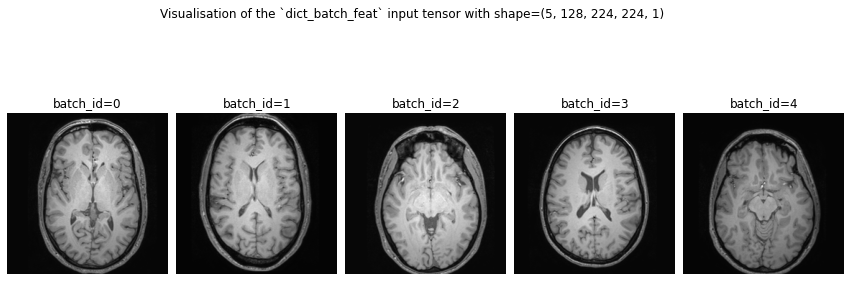

In [7]:
# Visualise the `dict_batch_feat` using matplotlib.
input_tensor_shape = dict_batch_feat.shape
center_slices = [s//2 for s in input_tensor_shape]

# Visualise the `gen_batch_feat` using matplotlib.
f, axarr = plt.subplots(1, input_tensor_shape[0], figsize=(15,5));
f.suptitle('Visualisation of the `dict_batch_feat` input tensor with shape={}'.format(input_tensor_shape))

for batch_id in range(input_tensor_shape[0]):
    # Extract a center slice image
    img_slice_ = np.squeeze(dict_batch_feat[batch_id, center_slices[1], :, :, :])
    img_slice_ = np.flip(img_slice_, axis=0)
    
    # Plot
    axarr[batch_id].imshow(img_slice_, cmap='gray');
    axarr[batch_id].axis('off')
    axarr[batch_id].set_title('batch_id={}'.format(batch_id))
    
f.subplots_adjust(wspace=0.05, hspace=0, top=0.8)
plt.show(); 